# Complete cifar-10 classification based on common machine learning algorithms.

1. linear methods
2. nonlinear methods
3. ensemble learning

author: ZhouHao, ZhangYi, LiuYuqing.

[References](https://github.com/zbaishancha)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from tqdm import tqdm
import requests
import tarfile
import pickle

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Data preparation and analysis

In [6]:
file_data = './datasets/cifar-10-python.tar.gz'
default_batch_path = './datasets/cifar-10-batches-py/'
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [20]:
def load_batch(name_file):
    import pickle
    with open(default_batch_path + name_file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    labels = dict[b'labels']
    data = dict[b'data']
    return labels, data

# data_batch_1 -- data_batch_5
label1, data1 = load_batch('data_batch_1')
data1.shape

(10000, 3072)

In [15]:
def Obtener_Todos_Batch():
    total_data = []
    total_label = []
    for i in range(1,6):
        label_temp, data_temp = load_batch('data_batch_' + str(i))
        total_data.extend(data_temp)
        total_label.extend(label_temp)
    return total_label, np.array(total_data)

In [16]:
# train_batch
total_label, total_data = Obtener_Todos_Batch()
total_data.shape

In [18]:
label_test, data_test = load_batch("test_batch")
data_test.shape

## Aplicando PCA

In [21]:
pca = PCA()
pca.fit_transform(total_data) # time costs

array([[-1.63225950e+03,  6.95904885e+02,  3.82936183e+02, ...,
        -1.94383396e-01, -2.96716275e-01, -8.91909421e-02],
       [ 2.11594763e+02, -2.42235521e+02,  1.53095691e+03, ...,
         2.76508201e-02,  1.47062424e-01, -1.96606511e-01],
       [ 1.97120094e+03, -2.93813609e+03, -7.02173229e+02, ...,
        -2.66373278e-01, -5.45969636e-02, -1.00334729e-01],
       ...,
       [ 1.80373380e+02, -2.89234292e+03, -1.00448294e+02, ...,
        -9.69870999e-02,  4.75402487e-01,  3.69202335e-01],
       [ 2.89881680e+03, -8.60874301e+02,  1.41938040e+03, ...,
        -1.19109692e-01,  1.89968105e-01, -4.26015893e-01],
       [ 1.06916310e+03, -3.01968063e+02, -1.13372056e+03, ...,
         2.46831906e-01,  6.12928127e-02, -7.15290870e-03]])

In [22]:
pca.explained_variance_

array([3.60000005e+06, 1.39326043e+06, 8.28840574e+05, ...,
       1.07089689e-01, 1.04648845e-01, 1.03207059e-01])

In [23]:
pca.explained_variance_.shape

(3072,)

In [24]:
pca_K = PCA()
pca_K.fit_transform(total_data)

array([[-1.63225950e+03,  6.95904885e+02,  3.82936183e+02, ...,
        -1.94383396e-01, -2.96716275e-01, -8.91909421e-02],
       [ 2.11594763e+02, -2.42235521e+02,  1.53095691e+03, ...,
         2.76508201e-02,  1.47062424e-01, -1.96606511e-01],
       [ 1.97120094e+03, -2.93813609e+03, -7.02173229e+02, ...,
        -2.66373278e-01, -5.45969636e-02, -1.00334729e-01],
       ...,
       [ 1.80373380e+02, -2.89234292e+03, -1.00448294e+02, ...,
        -9.69870999e-02,  4.75402487e-01,  3.69202335e-01],
       [ 2.89881680e+03, -8.60874301e+02,  1.41938040e+03, ...,
        -1.19109692e-01,  1.89968105e-01, -4.26015893e-01],
       [ 1.06916310e+03, -3.01968063e+02, -1.13372056e+03, ...,
         2.46831906e-01,  6.12928127e-02, -7.15290870e-03]])

In [25]:
def Calculate_Best_K_OPT():
    k = 0
    k_opt = 0
    total = sum(pca_K.explained_variance_)
    current_sum = 0
    k_values = []
    var_values = []
    while(k< 1000):
        if(current_sum / total < 0.99):
            k_opt = k
        current_sum += pca_K.explained_variance_[k]
        k_values.append(k)
        var_values.append(current_sum/total)
        k += 1
    return k, k_opt, k_values, var_values

In [26]:
k, k_opt, k_values, variance_values = Calculate_Best_K_OPT()

Text(0, 0.5, 'Varianza')

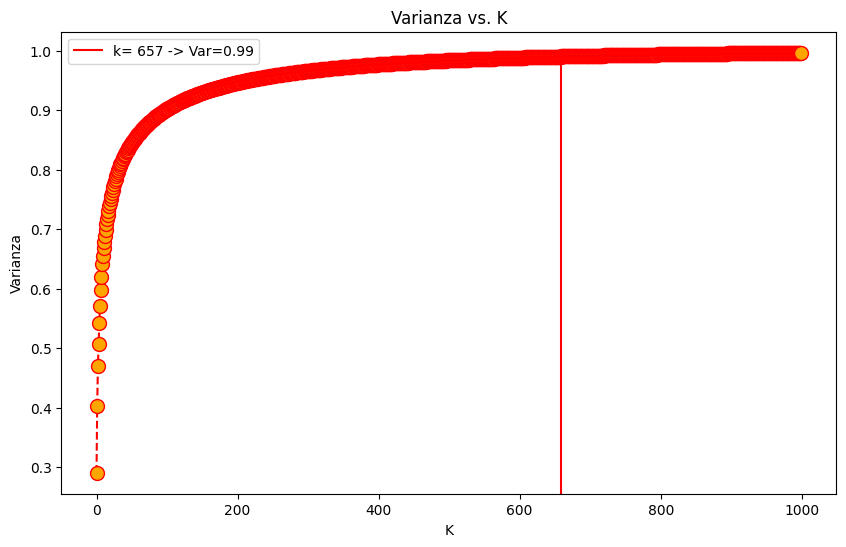

In [27]:
plt.figure(figsize=(10,6))
plt.plot(k_values,variance_values,color='red', linestyle='dashed', marker='o',
         markerfacecolor='orange', markersize=10)
plt.title('Varianza vs. K')
plt.xlabel('K')
plt.axvline(658, 0, 0.95,label='k= '+ str(k_opt) +' -> Var='+str(0.99),c='r')
plt.legend()
plt.ylabel('Varianza')

In [28]:
def Calculate_Best_K():
    k = 0
    total = sum(pca.explained_variance_)
    current_sum = 0
    
    while(current_sum / total < 0.99):
        current_sum += pca.explained_variance_[k]
        k += 1
    return k

In [29]:
Calculate_Best_K()

658

In [30]:
pca = PCA(n_components=Calculate_Best_K(), whiten=True)

x_train_pca = pca.fit_transform(total_data)
x_test_pca = pca.transform(data_test)

In [31]:
x_train_pca.shape

(50000, 658)

## ensemble learning
### RANDOM FOREST

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
rf = RandomForestClassifier()
rf.fit(x_train_pca, total_label) # time costs

RandomForestClassifier()

In [33]:
# predict result
label_predict_rf = rf.predict(x_test_pca)

random_forest_score = accuracy_score(label_test, label_predict_rf)
random_forest_score

0.3905

## linear methods
### Logistic Regression

In [34]:
lr = LogisticRegression()
lr.fit(x_train_pca, total_label)

LogisticRegression()

In [35]:
## Predicting
y_pred_lr = lr.predict(x_test_pca)
logistic_regression_score = accuracy_score(label_test, y_pred_lr)
logistic_regression_score

0.3983

### SVM

In [36]:
svc = svm.SVC()
svc.fit(x_train_pca, total_label) # time costs

SVC()

In [53]:
## Predicting 
y_pred_svm = svc.predict(x_test_pca)
svc_score = accuracy_score(label_test, y_pred_svm)
svc_score

0.4849

## nonlinear methods
### Kernel(RBF) SVM

In [39]:
import cv2
import numpy as np
from tqdm import tqdm
from statistics import mean
from joblib import dump, load
from tensorflow import keras
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

2023-12-16 00:00:02.146395: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-16 00:00:02.250618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-16 00:00:05.583527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### data preprocessing

In [40]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
assert y_train.shape == (50000,)
assert y_test.shape == (10000,)

In [41]:
def preprocess(xs):
    hog_imgs = []
    for x in tqdm(xs):
        gray = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) / 255
        fd = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                    	cells_per_block=(2, 2))
        hog_imgs.append(fd)
    return np.array(hog_imgs)

In [42]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

100%|██████████| 10000/10000 [00:03<00:00, 2797.58it/s]


In [43]:
print(x_train.shape)
print(x_test.shape)

(50000, 324)
(10000, 324)


In [44]:
pca = PCA(0.8)
pca.fit(x_train)
print(pca.n_components_)

66


In [45]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(0.8)), ('rbfsvc', SVC(kernel='rbf', C=10, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.8)),
                ('rbfsvc', SVC(C=10, cache_size=10000))])

In [46]:
dump(pipe, 'pipe.joblib')

['pipe.joblib']

In [47]:
pipe = load('pipe.joblib')

In [51]:
y_pred = pipe.predict(x_test)

rbf_svc_score = accuracy_score(label_test, y_pred)
rbf_svc_score


0.6199

## compare presicion de model

In [54]:
print("RandomForestClassifier : ", random_forest_score)
print("Logistic Regression : ", logistic_regression_score)
print("SVM(linear): ", svc_score)
print("SVM(rbf_nonlinear): ", rbf_svc_score)

RandomForestClassifier :  0.3905
Logistic Regression :  0.3983
SVM(linear):  0.4849
SVM(rbf_nonlinear):  0.6199
